Urban Data Science & Smart Cities <br>
URSP688Y <br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/ncsg/ursp688y_sp2024/blob/main/exercises/exercise10/exercise10.ipynb)

# Exercise 10

This last exercise is an opportunity for you to make progress on your final project. Please identify a portion of your project that you can reasonably address within the next three weeks and submit a notebook (and any other related files) where you:

1. State the question you are aiming to address with this portion of your analysis (likely a sub-question of the overarching question for your project)
2. Outline the approach you will use to answer that question
3. Operationalize your approach with data and code that you can later slot into your final product

If you are writing a proposal for your final project, please further discuss how and why you will propose using certain data and methods, and discuss the implications of these choices, in lieu of the third step above (writing code). You may submit a PDF document instead of a notebook.

For either type of project, please design the work you do for this exercise to contribute directly to your final product.

1. I am aiming to figure out the distribution of housing units with walking distance of the phase 1 Silver Line extension stations in Fairfax County.
2. To do so, I will be using an inputted spreadsheet that contains every housing unit within that area.
3. That spreadsheet will contain further details about the units including how many dwelling units are in each building, when they were constructed, and the type of building, as defined using the Fairfax County building type definitions.
4. In this exercise, I will be creating an overview map of the houses around the stations areas, the surrounding census tracts, and the buffer distances around the metro stations. I will work further on adding more details to the maps for the final project and presentation.
5. For this assignment I also prepared some graphs summarizing the current housing characteristics.

In [3]:
# Import packages
import os
import json
import requests
import pandas as pd
import datetime
from datetime import datetime
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import box

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Set the working directory
# You will need to change this to your own folder on Google Drive
os.chdir('/content/drive/MyDrive/ursp688y/Exercise 10')

In [6]:
# Load shapefile containing the locations of the five Phase 1 Metro stations: McLean, Tysons, Spring Hill, Greensboro, and Wiehle-Reston East

metro_stations = gpd.read_file('Metrorail_Stations.shp')
metro_stations = metro_stations.to_crs(4326)

In [7]:
# Load shapefile containing border of Fairfax County, where all five metro stations are.

ffx_county_boundary = gpd.read_file('Fairfax_County_Boundary.shp')
ffx_county_boundary = ffx_county_boundary.to_crs(4326)

In [8]:
# Load the census tracts that I am focusing on in my analysis.

tractdata = gpd.read_file('2010 Virginia Census Tracts.shp')
tractdata = tractdata.to_crs(4326)

In [ ]:
# Test plot to make sure only the tracts I'm interested in are plotted.

tractdata.plot(color='w',edgecolors='black')

In [18]:
# Load file containing all housing with 0.75 miles (walking distance) of a metro station.

Housing_within075 = gpd.read_file('Housing Units within 0_75 Miles of Stations.shp')
Housing_within075 = Housing_within075.to_crs(4326)

In [19]:
# Test to see what data the loaded shapefile has.

Housing_within075.head(1)

,FID_Curren,OBJECTID,PIN,PARCE_ID,VALID_FROM,VALID_TO,CURRE_UNIT,HOUSI_UNIT,LUC,YEAR_BUILT,...,NODE,YEAR_,GlobalID,CreationDa,Creator,EditDate,Editor,BUFF_DIST,ORIG_FID,geometry
0,68926,68927,0392 26050001,444707,None,2023-01-01,1,LR,041,1967,...,0,2014,4e1e6eb2-d915-4cec-aab7-3f9c082b5aa6,2024-04-07,FairfaxCounty,2024-04-07,FairfaxCounty,3960.0,22,POINT (-77.21458 38.91251)


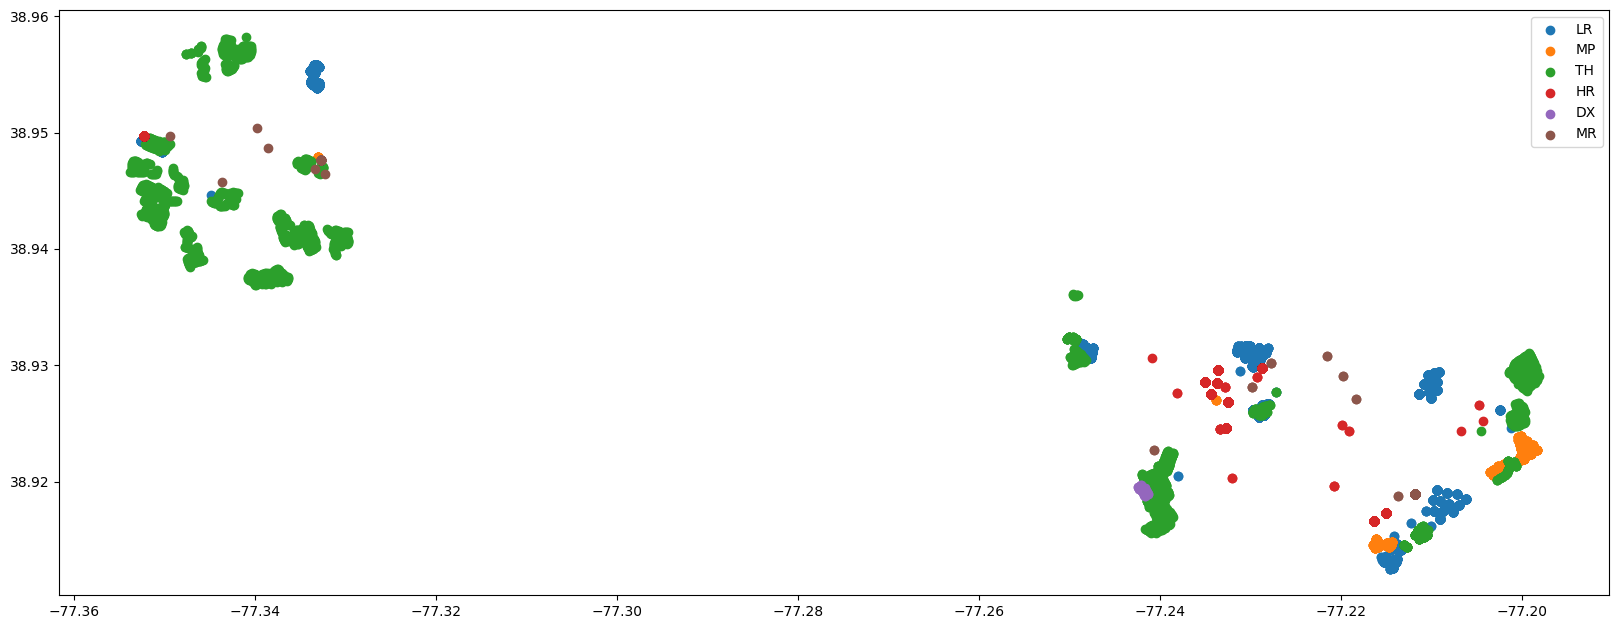

In [20]:
# Test plot of the housing data to ensure it is color coded for visual clarity.

# Prepare the Plotting Data
unique_attributes = Housing_within075['HOUSI_UNIT'].unique()
colors = plt.cm.tab10(range(len(unique_attributes)))  # Choose colormap and number of colors
attribute_color_dict = dict(zip(unique_attributes, colors))

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(20, 12))  # Set the figure size as per your preference
for attribute, color in attribute_color_dict.items():
    Housing_within075[Housing_within075['HOUSI_UNIT'] == attribute].plot(ax=ax, color=color, label=attribute)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [11]:
# Load file containing the buffers around the metro stations

metro_buffer_data = gpd.read_file('Metrorail_Stations_Buffer2.shp', crs=4326)
metro_buffer_data = metro_buffer_data.to_crs(4326)

In [12]:
# Load file containing the census block data withnin 0.75 miles (walking distance) of the metro station

blockdata75 = gpd.read_file('Block Data Within 0_75 Miles of Stations - Phase 1.shp')
blockdata75 = blockdata75.to_crs(4326)

In [ ]:
# Test plot of the blockdata GeoDataFrame.

blockdata75.plot(color='w', edgecolors='black')

In [14]:
# Load shapefile containing all housing units sorted into the census tracts near stations.

housing_units = gpd.read_file('Housing Units in Selected Census Tracts.shp')
housing_units = housing_units.to_crs(4326)

In [ ]:
# Created dict for sorting the dots representing the different housing types by color.

Housing_type_color_code = {'SF': 'red',
                'TH': 'gold',
                'MP': 'brown',
                'DX': 'tan',
                'LR': 'c',
                'MR': 'blue',
                'HR': 'navy'}
Housing_type_color_code

<ipython-input-23-b0134b306a96>:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


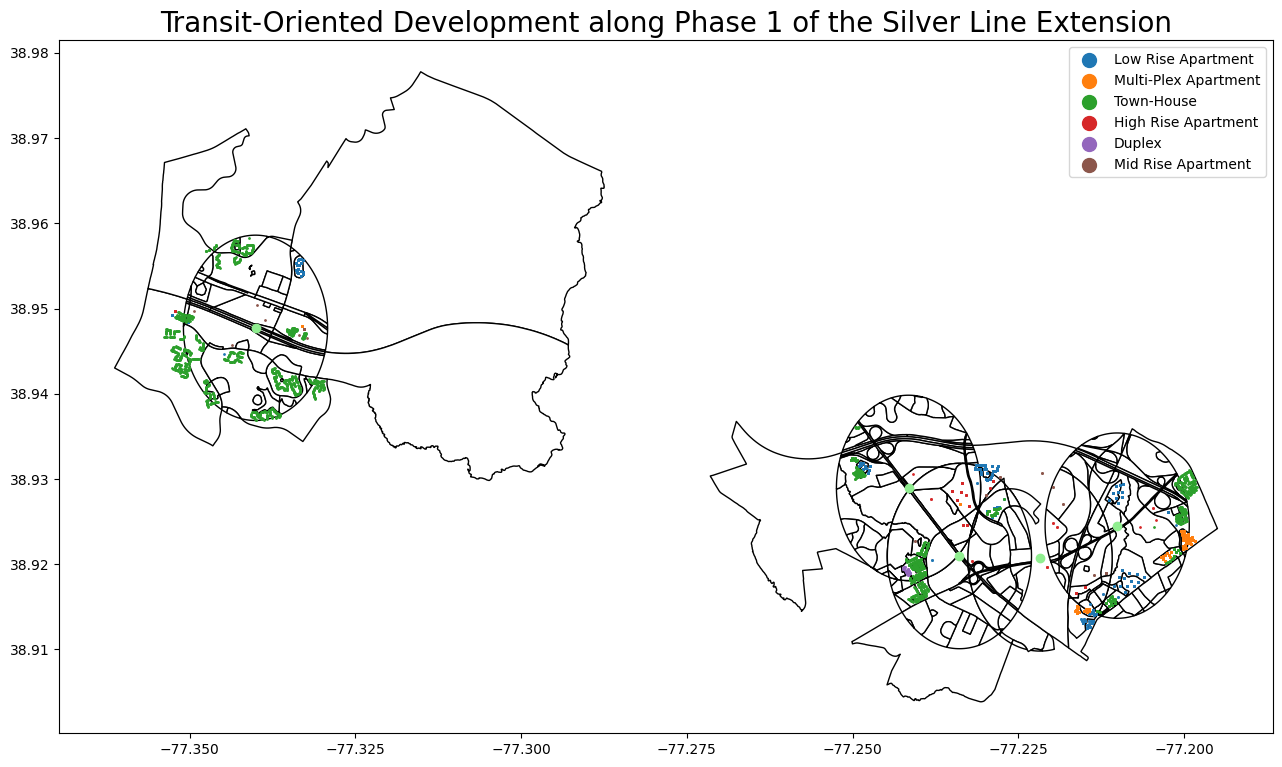

In [23]:
# Create map with housing, metro, stations, buffers, and selected census tract.

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(18, 9))

# Plot your background
tractdata.plot(ax=ax, color='w', edgecolor='black')
blockdata75.plot(ax=ax, color='w', edgecolor='black')

# Plot your foreground shapefile
metro_stations.plot(ax=ax, color='lightgreen')

# Plot Housing_within075 with different colors for different attributes
unique_attributes = Housing_within075['HOUSI_UNIT'].unique()
colors = plt.cm.tab10(range(len(unique_attributes)))  # Choose colormap and number of colors
attribute_color_dict = dict(zip(unique_attributes, colors))

for attribute, color in attribute_color_dict.items():
    Housing_within075[Housing_within075['HOUSI_UNIT'] == attribute].plot(ax=ax, color=color, markersize=1, label=attribute)

# Add title
plt.title("Transit-Oriented Development along Phase 1 of the Silver Line Extension", fontsize=20)

acronym_to_fullname = {
    'LR': 'Low Rise Apartment',
    'MP': 'Multi-Plex Apartment',
    'TH': 'Town-House',
    'HR': 'High Rise Apartment',
    'DX': 'Duplex',
    'MR': 'Mid Rise Apartment'
}

# Update legend labels
handles, labels = ax.get_legend_handles_labels()
updated_labels = [acronym_to_fullname[label] if label in acronym_to_fullname else label for label in labels]

# Create legend with larger handle size
legend = ax.legend(handles, updated_labels)
for handle in legend.legendHandles:
    handle.set_sizes([100])  # Set the size of the legend handle

# Show the plot
plt.show()

In [24]:
# Loading Census data

census_intersect = gpd.read_file('c2010VirginiaCensu_Intersect.shp', crs=4326)
census_intersect = census_intersect.to_crs(4326)

In [25]:
# Loading census data for graphical analysis

housing_units = pd.read_csv("Housing in SL zone.csv")
housing_units.head()

,OBJECTID_1,FID_Metrorail_Stations_Buffer,OBJECTID,NAME,STATION,NODE,YEAR_,GlobalID,CreationDa,Creator,...,OBJECTID.1,PIN,PARCE_ID,VALID_FROM,VALID_TO,CURRE_UNIT,HOUSI_UNIT,LUC,YEAR_BUILT,STRUC_DESC
0,1,24,324,GREENSBORO,0,0,2014,732d7bff-3f82-40bd-89ca-8311ea5faeae,4/7/2024,FairfaxCounty,...,76382,0391 45 0014,193035,NaN,1/1/2023,1,SF,11,2002,NaN
1,2,24,324,GREENSBORO,0,0,2014,732d7bff-3f82-40bd-89ca-8311ea5faeae,4/7/2024,FairfaxCounty,...,87267,0391 45 0013,293593,NaN,1/1/2023,1,SF,11,2002,NaN
2,3,24,324,GREENSBORO,0,0,2014,732d7bff-3f82-40bd-89ca-8311ea5faeae,4/7/2024,FairfaxCounty,...,122392,0391 45 0012,402814,NaN,1/1/2023,1,SF,11,2002,NaN
3,4,24,324,GREENSBORO,0,0,2014,732d7bff-3f82-40bd-89ca-8311ea5faeae,4/7/2024,FairfaxCounty,...,83609,0391 45 0011,376628,NaN,1/1/2023,1,SF,11,2002,NaN
4,5,24,324,GREENSBORO,0,0,2014,732d7bff-3f82-40bd-89ca-8311ea5faeae,4/7/2024,FairfaxCounty,...,83608,0391 45 0010,131234,NaN,1/1/2023,1,SF,11,2002,NaN


In [26]:
# Creating dicts for graph creation

Housing_type_dict = {'Single Family Detached': 0,
                     'Single Family Attached': 0,
                     'Multi Family': 0,
                     'Mobile Home': 0}

Unit_Count_dict = {'Single Family Detached': 0,
                     'Single Family Attached': 0,
                     'Multi Family': 0,
                     'Mobile Home': 0}

mf_unit_count_dict = {'Low Rise': 0,
                      'Mid Rise': 0,
                      'High Rise': 0}

mf_building_count = {'Low Rise': 0,
                      'Mid Rise': 0,
                      'High Rise': 0}

year_built_dict = {'Pre WWII': 0,
                   '1945 - 1960': 0,
                   '1961 - 1975': 0,
                   '1976 - 1990': 0,
                   '1991 - 2000': 0,
                   '2001 - 2005': 0,
                   '2006 - 2010': 0,
                   '2011 - 2015': 0,
                   '2016 - 2020': 0,
                   '2021 - Present': 0}

station_proximity_dict = {'Wiehle - Reston East': 0,
                          'Spring Hill': 0,
                          'Greensboro': 0,
                          'Tysons': 0,
                          'McLean': 0,}

In [27]:
# Calculating which transit stops have the most housing nearby. Faulty calculations so this won't be used for the final project.

for index, row in housing_units.iterrows():
  if (row['NAME'] == 'WIEHLE-RESTON EAST'):
    station_proximity_dict['Wiehle - Reston East'] = station_proximity_dict['Wiehle - Reston East'] + 1
  if (row['NAME'] == 'SPRING HILL'):
    station_proximity_dict['Spring Hill'] = station_proximity_dict['Spring Hill'] + 1
  if (row['NAME'] == 'Greensboro'):
    station_proximity_dict['Greensboro'] = station_proximity_dict['Greensboro'] + 1
  if (row['NAME'] == 'TYSONS'):
    station_proximity_dict['Tysons'] = station_proximity_dict['Tysons'] + 1
  if (row['NAME'] == 'MCLEAN'):
    station_proximity_dict['McLean'] = station_proximity_dict['McLean'] + 1

print(station_proximity_dict)

{'Wiehle - Reston East': 427, 'Spring Hill': 1278, 'Greensboro': 0, 'Tysons': 548, 'McLean': 1295}


In [28]:
# Counts total multi family dwellings by year built

for index, row in housing_units.iterrows():
#    if ((row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR') and (row['YEAR_BUILT'] < 1945)):
    if (row['YEAR_BUILT'] <= 1945):
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['Pre WWII'] = year_built_dict['Pre WWII'] + 1
    if (row['YEAR_BUILT'] > 1945 and row['YEAR_BUILT'] <= 1960):
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['1945 - 1960'] = year_built_dict['1945 - 1960'] + 1
    if (row['YEAR_BUILT'] > 1960 and row['YEAR_BUILT'] <= 1975):
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['1961 - 1975'] = year_built_dict['1961 - 1975'] + 1
    if (row['YEAR_BUILT'] >= 1976 and row['YEAR_BUILT'] <= 1990):
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['1976 - 1990'] = year_built_dict['1976 - 1990'] + 1
    if (row['YEAR_BUILT'] >= 1991 and row['YEAR_BUILT'] <= 2000):
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['1991 - 2000'] = year_built_dict['1991 - 2000'] + 1
    if (row['YEAR_BUILT'] >= 2001 and row['YEAR_BUILT'] <= 2005):
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['2001 - 2005'] = year_built_dict['2001 - 2005'] + 1
    if (row['YEAR_BUILT'] >= 2006 and row['YEAR_BUILT'] <= 2010):
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['2006 - 2010'] = year_built_dict['2006 - 2010'] + 1
    if (row['YEAR_BUILT'] >= 2011 and row['YEAR_BUILT'] <= 2015):
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['2011 - 2015'] = year_built_dict['2011 - 2015'] + 1
    if (row['YEAR_BUILT'] >= 2016 and row['YEAR_BUILT'] <= 2020):
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['2016 - 2020'] = year_built_dict['2016 - 2020'] + 1
    if row['YEAR_BUILT'] > 2020:
      if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
        year_built_dict['2021 - Present'] = year_built_dict['2021 - Present'] + 1

print(year_built_dict)

{'Pre WWII': 0, '1945 - 1960': 0, '1961 - 1975': 385, '1976 - 1990': 1917, '1991 - 2000': 1018, '2001 - 2005': 0, '2006 - 2010': 32, '2011 - 2015': 7, '2016 - 2020': 294, '2021 - Present': 5}


In [29]:
# Counts total dwellings for each unit type

for index, row in housing_units.iterrows():
    if (row['HOUSI_UNIT'] == 'SF'):
      Housing_type_dict['Single Family Detached'] = Housing_type_dict['Single Family Detached'] + 1
    if (row['HOUSI_UNIT'] == 'TH' or row['HOUSI_UNIT'] == 'MP' or row['HOUSI_UNIT'] == 'DX'):
      Housing_type_dict['Single Family Attached'] = Housing_type_dict['Single Family Attached'] + 1
    if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
      Housing_type_dict['Multi Family'] = Housing_type_dict['Multi Family'] + 1
    if (row['HOUSI_UNIT'] == 'MH'):
      Housing_type_dict['Mobile Home'] = Housing_type_dict['Mobile Home'] + 1

print(Housing_type_dict)

{'Single Family Detached': 244, 'Single Family Attached': 853, 'Multi Family': 3658, 'Mobile Home': 0}


In [30]:
# Counts total units for each housing type. The total units data is incomplete or inaccurate and won't be used for the final project or presentation

for index, row in housing_units.iterrows():
    if (row['HOUSI_UNIT'] == 'SF'):
      Unit_Count_dict['Single Family Detached'] = Unit_Count_dict['Single Family Detached'] + row['CURRE_UNIT']
    if (row['HOUSI_UNIT'] == 'TH' or row['HOUSI_UNIT'] == 'MP' or row['HOUSI_UNIT'] == 'DX'):
      Unit_Count_dict['Single Family Attached'] = Unit_Count_dict['Single Family Attached'] + row['CURRE_UNIT']
    if (row['HOUSI_UNIT'] == 'LR' or row['HOUSI_UNIT'] == 'MR' or row['HOUSI_UNIT'] == 'HR'):
      Unit_Count_dict['Multi Family'] = Unit_Count_dict['Multi Family'] + row['CURRE_UNIT']
    if (row['HOUSI_UNIT'] == 'MH'):
      Unit_Count_dict['Mobile Home'] = Unit_Count_dict['Mobile Home'] + row['CURRE_UNIT']

print(Unit_Count_dict)

{'Single Family Detached': 244, 'Single Family Attached': 870, 'Multi Family': 12139, 'Mobile Home': 0}


In [31]:
# Counts total units per multifamily housing type

for index, row in housing_units.iterrows():
    if (row['HOUSI_UNIT'] == 'LR'):
      mf_unit_count_dict['Low Rise'] = mf_unit_count_dict['Low Rise'] + row['CURRE_UNIT']
      mf_building_count['Low Rise'] = mf_building_count['Low Rise'] + 1
    if (row['HOUSI_UNIT'] == 'MR'):
      mf_unit_count_dict['Mid Rise'] = mf_unit_count_dict['Mid Rise'] + row['CURRE_UNIT']
      mf_building_count['Mid Rise'] = mf_building_count['Mid Rise'] + 1
    if (row['HOUSI_UNIT'] == 'HR'):
      mf_unit_count_dict['High Rise'] = mf_unit_count_dict['High Rise'] + row['CURRE_UNIT']
      mf_building_count['High Rise'] = mf_building_count['High Rise'] + 1

print(mf_unit_count_dict)
print(mf_building_count)

{'Low Rise': 1942, 'Mid Rise': 3797, 'High Rise': 6400}
{'Low Rise': 1437, 'Mid Rise': 154, 'High Rise': 2067}


In [32]:
for index, row in housing_units.iterrows():
    if (row['HOUSI_UNIT'] == 'LR'):
      mf_building_count['Low Rise'] = mf_building_count['Low Rise'] + 1
    if (row['HOUSI_UNIT'] == 'MR'):
      mf_building_count['Mid Rise'] = mf_building_count['Mid Rise'] + 1
    if (row['HOUSI_UNIT'] == 'HR'):
      mf_building_count['High Rise'] = mf_building_count['High Rise'] + 1

print(mf_building_count)

{'Low Rise': 2874, 'Mid Rise': 308, 'High Rise': 4134}


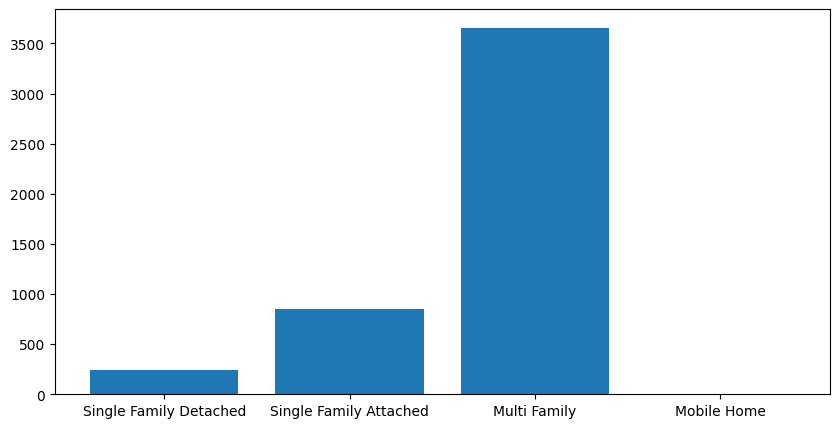

In [33]:
# Graphs total housing buildings in each type

plt.figure(figsize=(10, 5))
plt.bar(range(len(Housing_type_dict)), list(Housing_type_dict.values()), align='center')
plt.xticks(range(len(Housing_type_dict)), list(Housing_type_dict.keys()))

# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

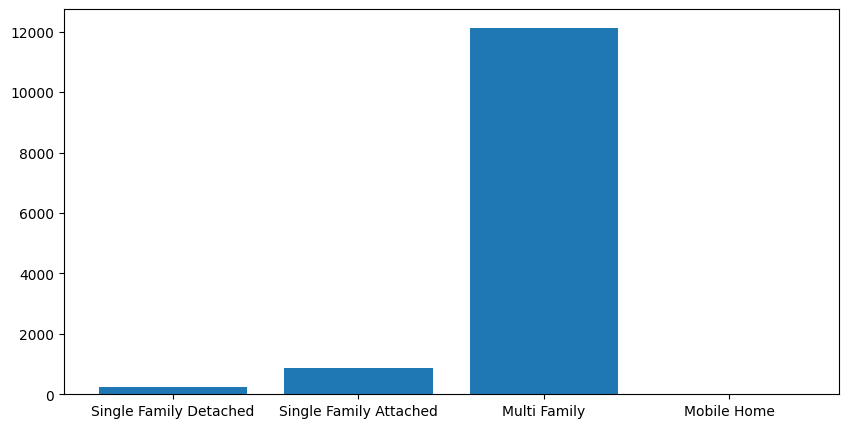

In [34]:
# Graphs total housing units of each type
# Faulty data for many apartments about how many units are in each

plt.figure(figsize=(10, 5))
plt.bar(range(len(Unit_Count_dict)), list(Unit_Count_dict.values()), align='center')
plt.xticks(range(len(Unit_Count_dict)), list(Unit_Count_dict.keys()))
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

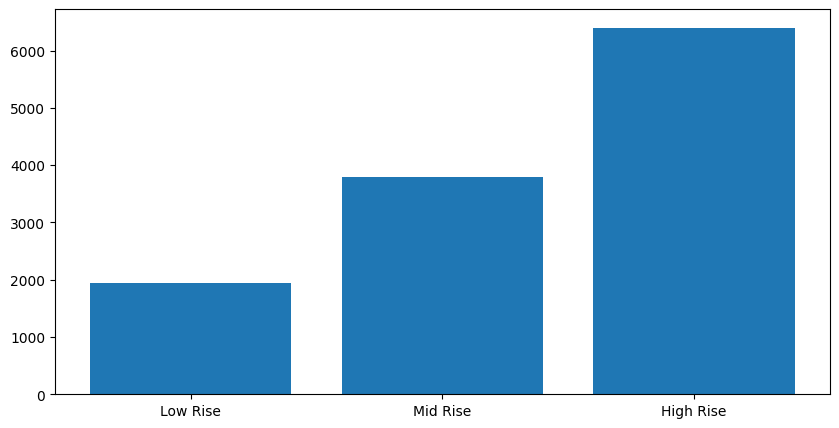

In [35]:
# Graphs total number of apartments for each apartment building type
# Faulty data for many apartments about how many units are in each

plt.figure(figsize=(10, 5))
plt.bar(range(len(mf_unit_count_dict)), list(mf_unit_count_dict.values()), align='center')
plt.xticks(range(len(mf_unit_count_dict)), list(mf_unit_count_dict.keys()))

# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()

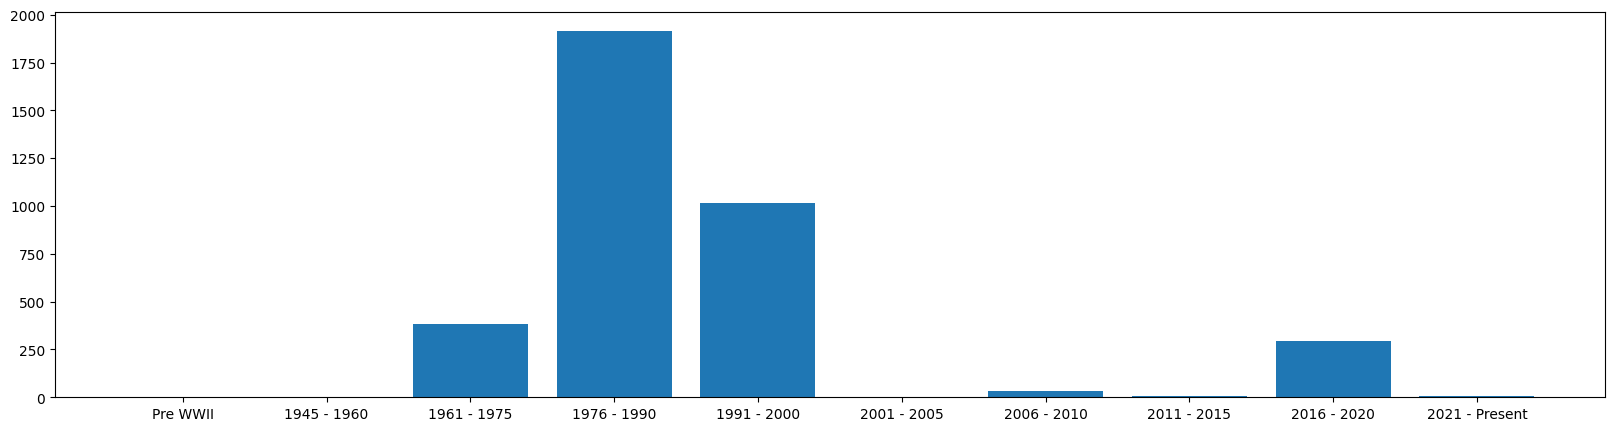

In [36]:
# Graphs total number of multi family units built in each timeframe

plt.figure(figsize=(20, 5))
plt.bar(range(len(year_built_dict)), list(year_built_dict.values()), align='center')
plt.xticks(range(len(year_built_dict)), list(year_built_dict.keys()))

# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()